## Conceptos clave
El entrenamiento se compone de varias **iteraciones** que se realizan durante el tiempo que se le ha asignado al entrenamiento.

Cada iteración se compone de varios **episodios** según el múmero que hayamos definido en el hiperparámetro correspondiente.

Un **episodio** es un período en el que el vehículo **comienza desde un determinado punto de partida y acaba completando la pista o saliéndose de ella**.

Cada episodio se compone de varios **pasos**. Cada paso es una de las **15 veces por segundo** que se ejecuta la función de recompensa según lo que ha captado la cámara.

In [ ]:
import pandas as pd
import re
import importlib.util
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from decimal import *


In [ ]:
# Fichero que coniene los logs *-robomaker.log
fichero_log = "/content/training-20251021060908-8_kwmnU0TY-ULRDnlQz8tw-robomaker.log"

# Fichero con el trazado del circuito
fichero_circuito = "Baadal_Track.py"

In [ ]:
EPISODIOS_POR_ITERACION = 5 #  Ponemos el valor de nuestro hiperparámetro en el entrenamiento

In [ ]:
# Extraemos los datos a analizar del fichero de logs y los dejamos en el data frame df

rows = []
with open(fichero_log, "r") as f:
    for line in f:
        if line.startswith("SIM_TRACE_LOG"):
            # Separar la parte después de los dos puntos (:)
            datos = line.split(":", 1)[1]
            parts = datos.split(",")
            episode = int(parts[0])
            steps = int(parts[1])
            x = 100 * float(parts[2])
            y = 100 * float(parts[3])
            yaw = float(parts[4])
            steer = float(parts[5])
            throttle = float(parts[6])
            action = float(parts[7])
            reward = float(parts[8])
            done = 0 if 'False' in parts[9] else 1
            all_wheels_on_track = parts[10]
            progress = float(parts[11])
            closest_waypoint = int(parts[12])
            track_len = float(parts[13])
            tstamp = Decimal(parts[14])

            iteration = int(episode / EPISODIOS_POR_ITERACION) + 1

            rows.append((iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress, closest_waypoint, track_len, tstamp))

df = pd.DataFrame(rows, columns=["iteration", "episode", "steps", "x", "y", "yaw", "steer", "throttle", "action", "reward", "done", "all_wheels_on_track", "progress", "closest_waypoint", "track_len", "tstamp"])



In [ ]:
# Comprobamos que se ha cargado el df y visualizamos la cantidad de pasos (filas) que se han hecho durante el entrenamiento

pd.set_option('display.max_rows', 10)             # Muestra 10 filas (5 primeras y 5 últimas)
pd.set_option('display.expand_frame_repr', 0)     # No corta las líneas

df

In [ ]:
# Comprobamos que los valores cargados coinciden con los mostrados en el gráfico de entrenamiento

suma_por_ep = df.groupby(['iteration','episode'])['reward'].sum().reset_index()

# Calcular la media de esas sumas dentro de cada iteración
media_por_iter = suma_por_ep.groupby('iteration')['reward'].mean()

print("\nMedia de la suma de recompensas por episodio en cada iteración:")
print(media_por_iter)

In [ ]:
# Analizamos una iteración (se compone de varios episodios)

iteracion_a_analizar = 1

pd.set_option('display.max_rows', None)      # Muestra todas las filas
pd.set_option('display.max_columns', None)   # Muestra todas las columnas
pd.set_option('display.width', None)         # Ajusta el ancho
pd.set_option('display.expand_frame_repr', 0) # No corta las líneas

df_it = df[df['iteration'] == iteracion_a_analizar]
print(df_it)

## Estadísticas por episodio

In [ ]:

# Agrupar por episodio y calcular los valores solicitados
resumen = df.groupby('episode').agg(
    total_reward=('reward', 'sum'),
    total_progress=('progress', 'last'),
    total_time=('tstamp', lambda x: x.iloc[-1] - x.iloc[0]),
    total_steps=('steps', 'count'),
).reset_index()

resumen['eficiencia'] = resumen['total_progress'] / resumen['total_steps']


In [ ]:
# Mostrar el resultado
#display(resumen)


In [ ]:
# Obtenemos 10 mejores episodios por progreso
mejores = resumen.sort_values(by='total_progress', ascending=False).head(10)
display(mejores)


,episode,total_reward,total_progress,total_time,total_steps,eficiencia
125,125,5476.6237,100.0000,25.393,382,0.261780
133,133,4791.6427,92.3073,24.537,369,0.250155
138,138,3401.0089,67.4190,17.717,267,0.252506
143,143,3063.3044,65.5578,16.964,255,0.257089
139,139,2891.2893,56.0786,14.963,225,0.249238
152,152,2539.4999,46.7935,11.868,179,0.261416
136,136,2133.4821,44.4810,11.801,178,0.249893
145,145,2234.0310,44.4050,11.484,173,0.256676
102,102,2194.6435,40.0772,9.991,151,0.265412
144,144,2044.8740,39.8507,10.274,155,0.257101


In [ ]:
# Obtenemos 10 mejores episodios por recompensa
mejores = resumen.sort_values(by='total_reward', ascending=False).head(10)
display(mejores)

,episode,total_reward,total_progress,total_time,total_steps,eficiencia
125,125,5476.6237,100.0000,25.393,382,0.261780
133,133,4791.6427,92.3073,24.537,369,0.250155
138,138,3401.0089,67.4190,17.717,267,0.252506
143,143,3063.3044,65.5578,16.964,255,0.257089
139,139,2891.2893,56.0786,14.963,225,0.249238
152,152,2539.4999,46.7935,11.868,179,0.261416
145,145,2234.0310,44.4050,11.484,173,0.256676
102,102,2194.6435,40.0772,9.991,151,0.265412
136,136,2133.4821,44.4810,11.801,178,0.249893
144,144,2044.8740,39.8507,10.274,155,0.257101


In [ ]:
# Obtenemos 10 mejores episodios por eficiencia
mejores = resumen.sort_values(by='eficiencia', ascending=False).head(10)
display(mejores)

,episode,total_reward,total_progress,total_time,total_steps,eficiencia
109,109,724.9152,16.5399,3.807,58,0.285171
77,77,1474.9230,29.6364,7.003,106,0.279589
97,97,1872.7564,34.8302,8.316,126,0.276430
110,110,569.8989,15.0717,3.616,55,0.274031
132,132,1097.7816,24.0314,5.808,88,0.273084
87,87,1380.3951,27.1706,6.675,101,0.269016
99,99,1122.5071,24.0279,5.961,90,0.266977
98,98,1981.0718,36.0342,8.928,135,0.266920
102,102,2194.6435,40.0772,9.991,151,0.265412
53,53,1126.6305,25.0136,6.28,95,0.263301


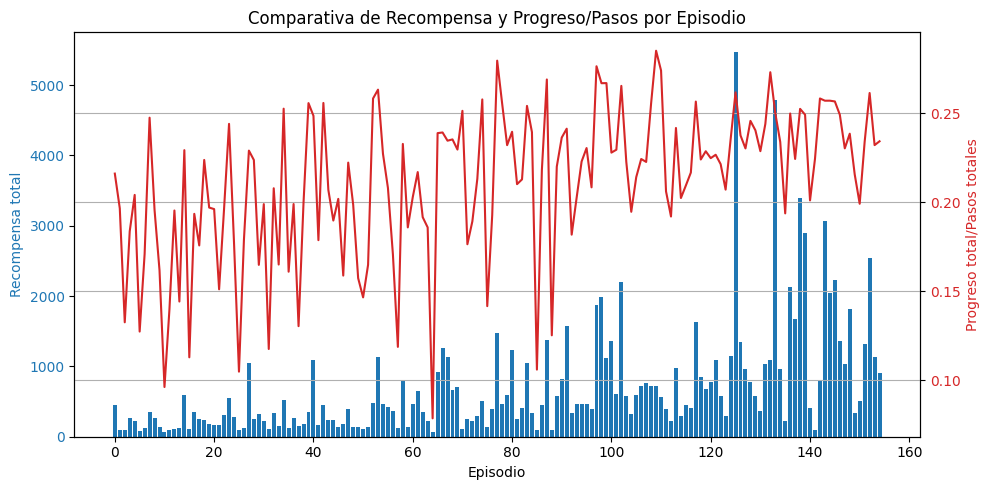

In [ ]:
# Gráfico comparativo de Recompensa y Progreso/Pasos (eficiencia)

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje izquierdo: total_reward
color = 'tab:blue'
ax1.set_xlabel('Episodio')
ax1.set_ylabel('Recompensa total', color=color)
ax1.bar(resumen['episode'], resumen['total_reward'], color=color, label='Recompensa total')
ax1.tick_params(axis='y', labelcolor=color)

# Crear el segundo eje (compartiendo el eje X)
ax2 = ax1.twinx()

# Eje derecho: total_progress
color = 'tab:red'
ax2.set_ylabel('Progreso total/Pasos totales', color=color)
ax2.plot(resumen['episode'], resumen['eficiencia'], color=color, linestyle='-', label='Progreso total / pasos')
ax2.tick_params(axis='y', labelcolor=color)

# Título y cuadrícula
plt.title('Comparativa de Recompensa y Progreso/Pasos por Episodio')
fig.tight_layout()
plt.grid(True)
plt.show()


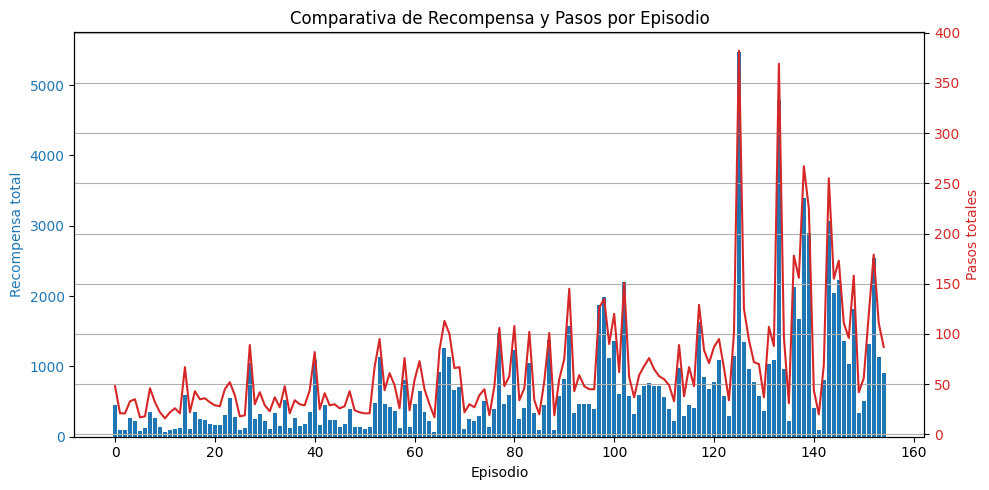

In [ ]:
# Gráfico comparativo de Recompensa y Pasos

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje izquierdo: total_reward
color = 'tab:blue'
ax1.set_xlabel('Episodio')
ax1.set_ylabel('Recompensa total', color=color)
ax1.bar(resumen['episode'], resumen['total_reward'], color=color, label='Recompensa total')
ax1.tick_params(axis='y', labelcolor=color)

# Crear el segundo eje (compartiendo el eje X)
ax2 = ax1.twinx()

# Eje derecho: total_progress
color = 'tab:red'
ax2.set_ylabel('Pasos totales', color=color)
ax2.plot(resumen['episode'], resumen['total_steps'], color=color, linestyle='-', label='Pasos totales')
ax2.tick_params(axis='y', labelcolor=color)

# Título y cuadrícula
plt.title('Comparativa de Recompensa y Pasos por Episodio')
fig.tight_layout()
plt.grid(True)
plt.show()

## Análisis gráfico de 2 episodios

In [ ]:
# Por ejemplo, queremos los valores de x e y del episodio 1:
episodio_1 = 125
episodio_2 = 97

# Filtramos las filas del episodio
df_ep1 = df[df['episode'] == episodio_1]
df_ep2 = df[df['episode'] == episodio_2]

# Extraemos las columnas x e y
x_ep1 = (df_ep1['x'].values)/100
y_ep1 = (df_ep1['y'].values)/100

x_ep2 = (df_ep2['x'].values)/100
y_ep2 = (df_ep2['y'].values)/100


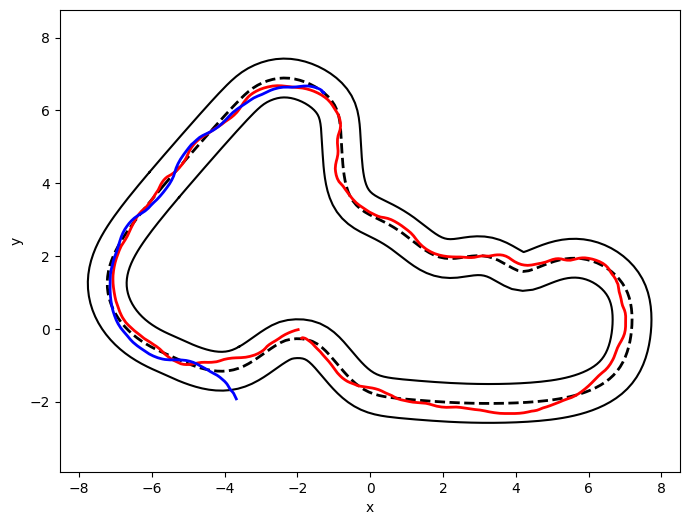

In [ ]:

# --- Cargar dinámicamente el fichero .py ---
spec = importlib.util.spec_from_file_location("pista", fichero_circuito)
pista = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pista)

# --- Obtener las variables ---
track_width = pista.track_width
track_original = np.array(pista.track_original)

# --- Extraer coordenadas ---
x, y = track_original[:, 0], track_original[:, 1]

# --- Calcular vectores normales para las líneas paralelas ---
dx = np.gradient(x)
dy = np.gradient(y)

norm = np.sqrt(dx**2 + dy**2)
nx = -dy / norm
ny = dx / norm

offset = track_width / 2
x_left = x + nx * offset
y_left = y + ny * offset
x_right = x - nx * offset
y_right = y - ny * offset

# --- Graficar ---
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'k--', linewidth=2)
plt.plot(x_left, y_left, 'k-')
plt.plot(x_right, y_right, 'k-')

plt.plot(x_ep1, y_ep1, 'r-', linewidth=2)
plt.plot(x_ep2, y_ep2, 'b-', linewidth=2)

plt.axis('equal')
# plt.title('Circuito Baadal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()